![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 29 - Convolutional Neural Network</center>
### <center> 2D CNN</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/29_CNN/MainCnn2D.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#-- torch:
import torch

For Colab users:

In [4]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/MachineLearningMethod/29_CNN/Cnn2D_Aux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#-- Record figures during training:
from Cnn2D_Aux import TrainLoop, ValidationLoop, TrainModel

### Download CIFAR10 dataset:

In [6]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape

Files already downloaded and verified
Files already downloaded and verified


(50000, 32, 32, 3)

In [7]:
lClasses  = oTrainSet.classes
lClasses

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Plot some examples:

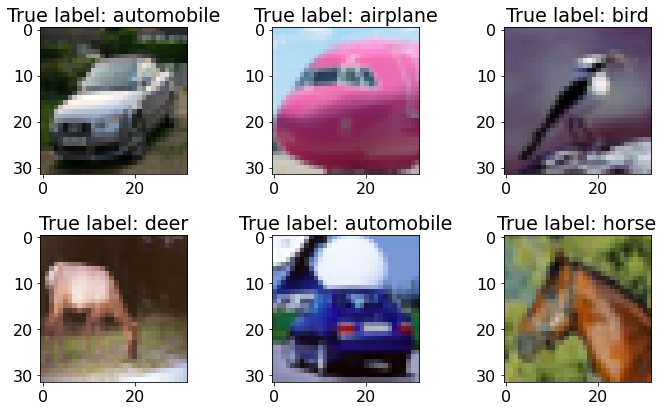

In [11]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    ax.imshow(np.transpose(mX.numpy(), [1, 2, 0]))
    ax.set_title('True label: ' + str(lClasses[y]))
    
plt.tight_layout()
plt.show()

### Compute mean and variance:

In [12]:
vMean = oTrainSet.data.mean(axis=(0,1,2)) / 255
vStd  = oTrainSet.data.std (axis=(0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


### Set datasets with normalization:

In [13]:
oTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(vMean, vStd)
])

oTrainSet.transform = oTransform
oTestSet .transform = oTransform

### Create data loaders:

In [14]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

### Define the model (2D CNN):

In [18]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary

#-- Tensor to vector (reshape):
class Flatten(nn.Module):
    def forward(self, input):
        out = input.view(input.size(0),-1)
        return out

    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Sequential(), #-- does nothing
        
        nn.Conv2d     (in_channels=3,   out_channels=30,  kernel_size=3, bias=False),
        nn.BatchNorm2d(num_features=30),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
        
        nn.Conv2d     (in_channels=30,  out_channels=60,  kernel_size=3, bias=False),
        nn.MaxPool2d  (kernel_size=2),
        nn.BatchNorm2d(num_features=60),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
                
        nn.Conv2d     (in_channels=60,  out_channels=120, kernel_size=3, bias=False),
        nn.BatchNorm2d(120),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        
        nn.Conv2d     (in_channels=120, out_channels=240, kernel_size=3, bias=False),
        nn.BatchNorm2d(240),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
        
        nn.Conv2d     (in_channels=240, out_channels=500, kernel_size=3, bias=False),
        nn.MaxPool2d  (2),
        nn.BatchNorm2d(500),
        nn.ReLU       (),
        
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(500, 10),
    )
    
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), (C, H, W), device='cpu')
print()

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
├─Conv2d: 1-2                            [-1, 30, 30, 30]          810
├─BatchNorm2d: 1-3                       [-1, 30, 30, 30]          60
├─ReLU: 1-4                              [-1, 30, 30, 30]          --
├─Dropout2d: 1-5                         [-1, 30, 30, 30]          --
├─Conv2d: 1-6                            [-1, 60, 28, 28]          16,200
├─MaxPool2d: 1-7                         [-1, 60, 14, 14]          --
├─BatchNorm2d: 1-8                       [-1, 60, 14, 14]          120
├─ReLU: 1-9                              [-1, 60, 14, 14]          --
├─Dropout2d: 1-10                        [-1, 60, 14, 14]          --
├─Conv2d: 1-11                           [-1, 120, 12, 12]         64,800
├─BatchNorm2d: 1-12                      [-1, 120, 12, 12]         240
├─ReLU: 1-13                             [-1, 120, 12, 12]         --
├─Dr

### Check whether GPU is available:

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

### Train the model:

<IPython.core.display.Javascript object>


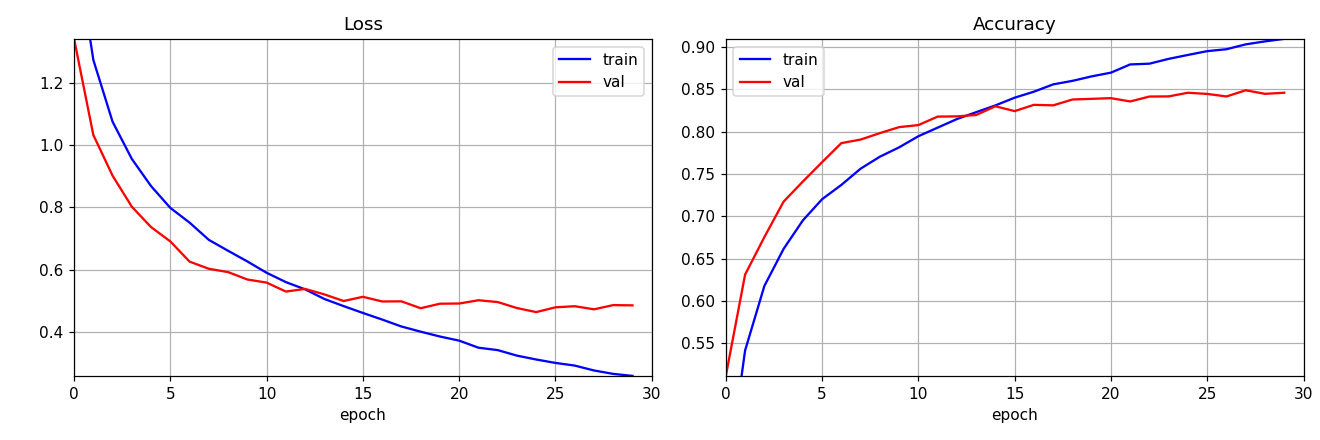

Epoch   0: | Train loss: 1.67761 | Val loss: 1.34110 | Train Accuracy: 0.3771 | Val Accuracy: 0.5116 | epoch time: 20.622 | <-- Checkpoint!
Epoch   1: | Train loss: 1.27352 | Val loss: 1.03261 | Train Accuracy: 0.5416 | Val Accuracy: 0.6312 | epoch time: 19.947 | <-- Checkpoint!
Epoch   2: | Train loss: 1.07501 | Val loss: 0.90190 | Train Accuracy: 0.6177 | Val Accuracy: 0.6755 | epoch time: 19.701 | <-- Checkpoint!
Epoch   3: | Train loss: 0.95572 | Val loss: 0.80233 | Train Accuracy: 0.6616 | Val Accuracy: 0.7174 | epoch time: 19.231 | <-- Checkpoint!
Epoch   4: | Train loss: 0.86841 | Val loss: 0.73698 | Train Accuracy: 0.6952 | Val Accuracy: 0.7411 | epoch time: 19.078 | <-- Checkpoint!
Epoch   5: | Train loss: 0.79859 | Val loss: 0.69101 | Train Accuracy: 0.7203 | Val Accuracy: 0.7640 | epoch time: 19.249 | <-- Checkpoint!
Epoch   6: | Train loss: 0.75133 | Val loss: 0.62612 | Train Accuracy: 0.7372 | Val Accuracy: 0.7865 | epoch time: 20.455 | <-- Checkpoint!
Epoch   7: | Train l

In [20]:
%matplotlib notebook

oModel    = GetModel().to(device)
oOptim    = optim.AdamW(oModel.parameters(), lr=4e-3, betas=(0.9, 0.99), weight_decay=1e-2)
LossFunc  = nn.CrossEntropyLoss()
numEpochs = 30

TrainModel(oModel, oTrainDL, oTestDL, LossFunc, numEpochs, oOptim)

### Exercise
* Load the Fashion-MNIST dataset.
* Use 2D CNN, try to get the high accuracy (above 93% is good).

In [21]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape

torch.Size([60000, 28, 28])

In [22]:
lClasses  = oTrainSet.classes
lClasses

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

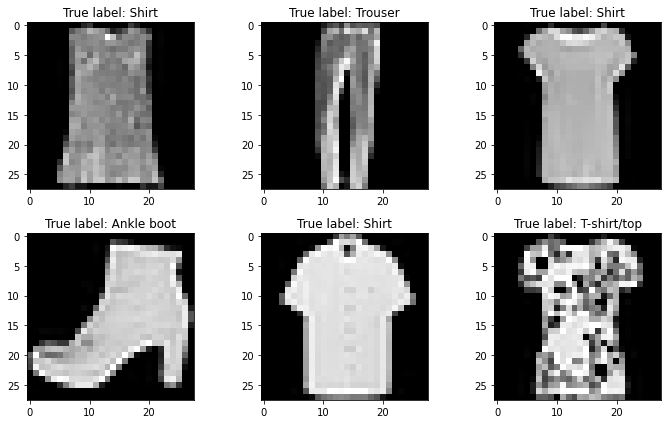

In [24]:
#%matplotlib inline

N, H, W = oTrainSet.data.shape
fig, _  = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    ax.imshow(mX.squeeze(), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[y]))
    
plt.tight_layout()
plt.show()

In [25]:
???

Object `?` not found.


In [26]:
????

Object `??` not found.
